In [2]:
import sys 

sys.path.append('./project_playground/QEC-with-spin-qubits/')

In [3]:
from RotatedSurfaceCode import RotatedSurfaceCode
from SurfaceCode3CX import SurfaceCode3CX
from XZZXCode import XZZXCode
from HeavyHEXFloquetColorCode import HeavyHexFloquetColorCode
from HeavyHEXHoneycombFloquetCode import HeavyHexHoneycombFloquetCode
from XYZ2Code import XYZ2Code
import plot_utils

import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.optimize import fsolve
from math import comb


In [3]:
T1 = 3_300 #us
T2 = 50 #T2 of an idling qubit with arbitrary dynamical decoupling protocol 
Fidelity_RO = 0.99
Readout_time = 6
Fidelity_init = 0.995
Init_time = 2
Fidelity_1Q = 0.996
Fidelity_2Q = 0.996

pT1 = (1-np.exp(-(Readout_time+Init_time)/T1))/4 #relaxation, assuming exponential decay
pT2 = (1-np.exp(-(Readout_time+Init_time)**2/T2**2))/2 - (1-np.exp(-(Readout_time+Init_time)/T1))/4 #dephasing, assuming Gaussian decay
pRR = (1-Fidelity_RO)*Fidelity_init + (1-Fidelity_init)*Fidelity_RO
pG1 = 1-Fidelity_1Q
pG2 = 1-Fidelity_2Q

# pR = 15/31*pRR
f = lambda pR: sum([comb(2,i)*(8*pR/15)**i*(1-8*pR/15)**(2-i)*pR**j*(1-pR)**(1-j) for i in range(3) for j in range(2) if i+j%2])-pRR
pR = fsolve(f,pRR)[0]#inverting the formula of pRR(pR)
etaT = pT2/pT1
pT = pT1 + pT2
etaG= pG2/pG1
pG = (pG1 + pG2)/2
p_physR = np.sqrt(pG**2 + pT**2 + pR**2)
phi = np.arctan2(pT,pG)
thetaR = np.arctan2(pR,np.sqrt(pT**2 + pG**2))
p_physR

0.015105700467154518

UnboundLocalError: cannot access local variable 'e_connectivity' where it is not associated with a value

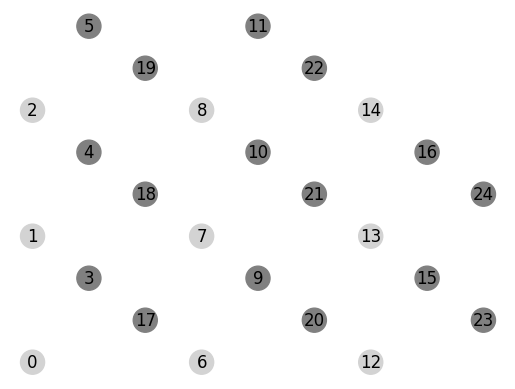

In [4]:
d: int = 3
T: int = 0
logical_observable: str = "Z"
gate_error_1q: float = pG1
gate_error_2q: float = pG2
idle_error_T1: float = pT1
idle_error_T2: float = pT2
measurement_error_rate: float = pRR
noisyLogRO: float = 1
# rsc = RotatedSurfaceCode(d=d,T=T,logical_observable=logical_observable,gate_error_1q=gate_error_1q,gate_error_2q=gate_error_2q,idle_error_T1=idle_error_T1,idle_error_T2=idle_error_T2,measurement_error_rate=measurement_error_rate,noisyLogRO=noisyLogRO)

rsc = SurfaceCode3CX(d=d,T=T,logical_observable=logical_observable,gate_error_1q=gate_error_1q,gate_error_2q=gate_error_2q,idle_error_T1=idle_error_T1,idle_error_T2=idle_error_T2,measurement_error_rate=measurement_error_rate)
rsc.draw_lattice()



In [7]:
di = 13
Ti = 13
rsc = SurfaceCode3CX(d=di,T=Ti,logical_observable=logical_observable,gate_error_1q=gate_error_1q,gate_error_2q=gate_error_2q,idle_error_T1=idle_error_T1,idle_error_T2=idle_error_T2,measurement_error_rate=measurement_error_rate)
# rsc.draw_lattice()

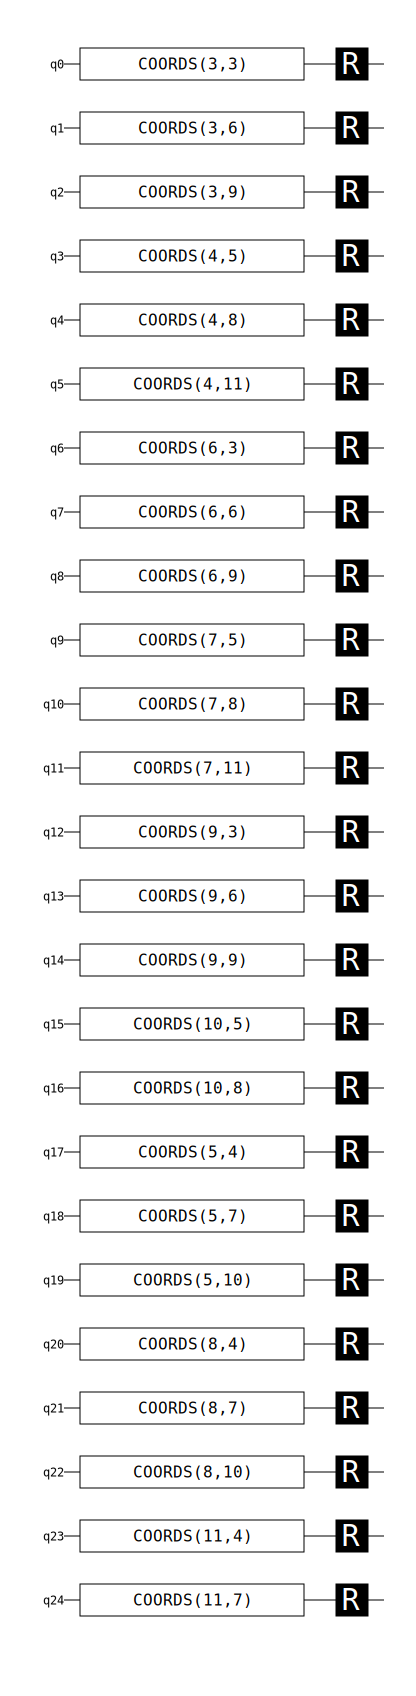

In [5]:
import stim



rsc.initialize_stim_circuit().diagram('timeline-svg')

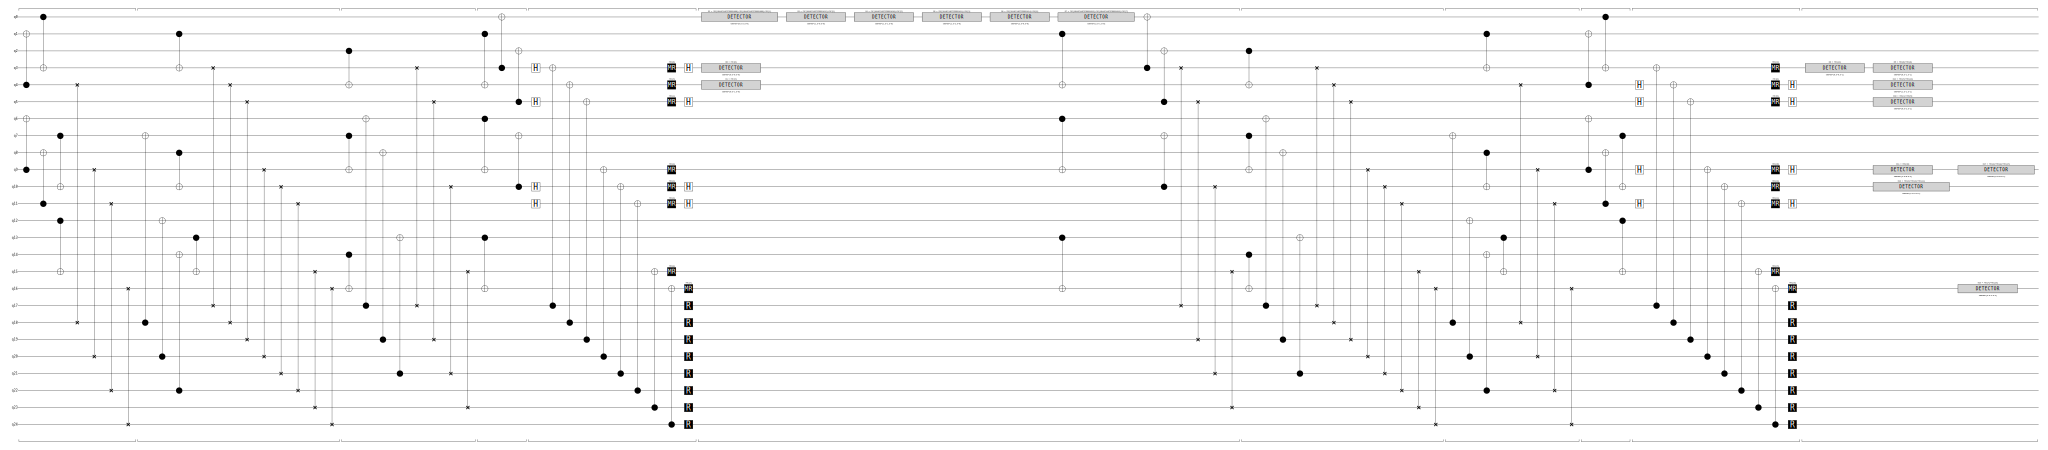

In [6]:
rsc.generate_stim_circuit_cycle().diagram('timeline-svg')

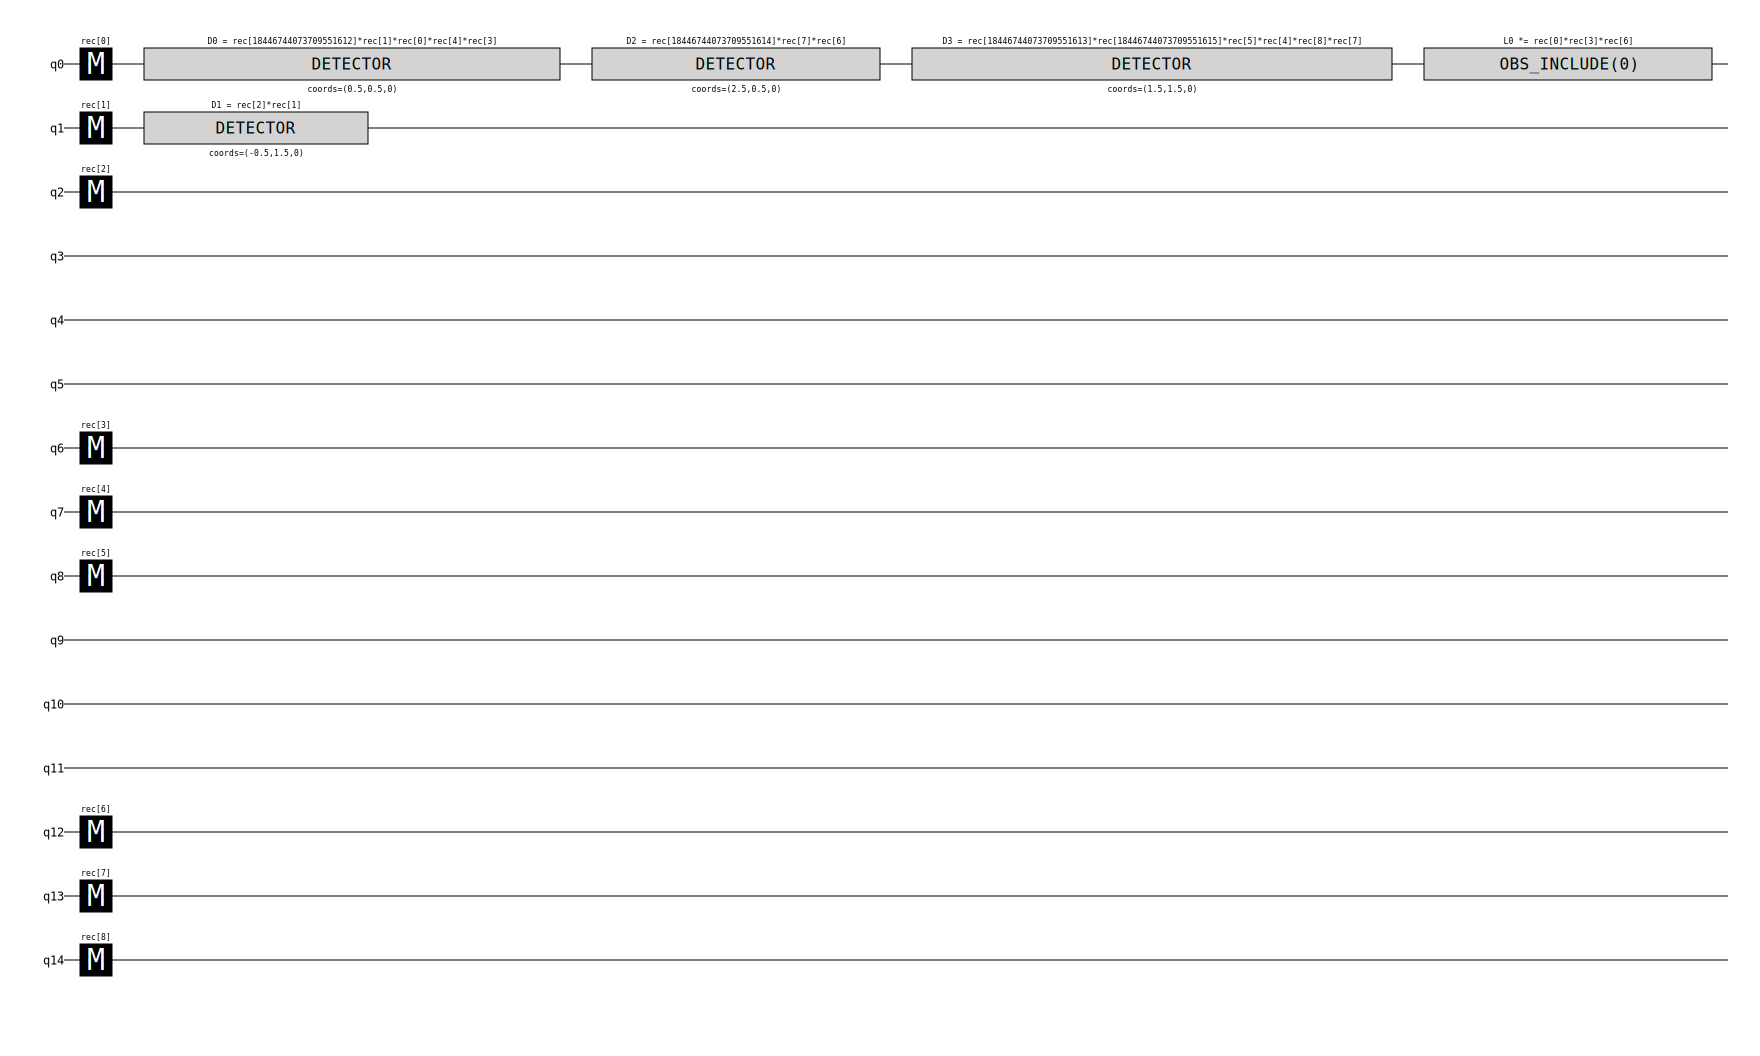

In [7]:
rsc.final_measurement_stim_circuit().diagram('timeline-svg')

In [8]:
num_shots = 50000

sampler = rsc.stim_circuit.compile_detector_sampler()
syndrome, actual_observables = sampler.sample(shots=num_shots, separate_observables=True)

# actual_observables.shape
import pymatching
model = rsc.stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)
# m = rsc.matching()
predicted_observables = matching.decode_batch(syndrome)
num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))

print(num_errors,num_shots)  # prints 8
print(num_errors/num_shots)

1670 50000
0.0334


In [79]:
shots = 1000
m = rsc.matching()
num_fail = 0.0
num_correct = 0.0
sampler = rsc.stim_circuit.compile_detector_sampler()
syndrome,actual_observables = sampler.sample(shots=shots, separate_observables=True) 
# decoded = m.decode_batch(syndrome)
# preds = np.array([rsc.PredictedObservableOutcome(sample=d,m=m) for d in actual_observables])
# for sample in detector_samples:
#     actual_observable = sample[-1]
#     detectors_only = sample.copy()
#     detectors_only[-1] = 0
#     predicted_observable = rsc.PredictedObservableOutcome(sample=detectors_only,m=m)
#     num_fail += actual_observable != predicted_observable
#     num_correct += actual_observable == predicted_observable

# print(num_fail,num_correct)

# np.sum(decoded == preds)

ValueError: `shots` array should have at least 13 columns (the number of detectors), and no more than 14 columns (the number of nodes), but instead has 12 columns

In [15]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(RotatedSurfaceCode, 
                                                    theta = 0, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(11,17+1,2), error_list = np.linspace(0.001,0.03,10), T_over_d = 1,
                                                    max_shots = 10000, shot_batch = 100, max_num_fail = 1000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.004267415228914087

In [12]:
list(range(11,18,2))

[11, 13, 15, 17]

In [29]:
circ = rsc.stim_circuit
# sim = stim.CompiledDetectorSampler(circ)
sim = stim.CompiledMeasurementSampler(circ)

# sim.sample(circ)

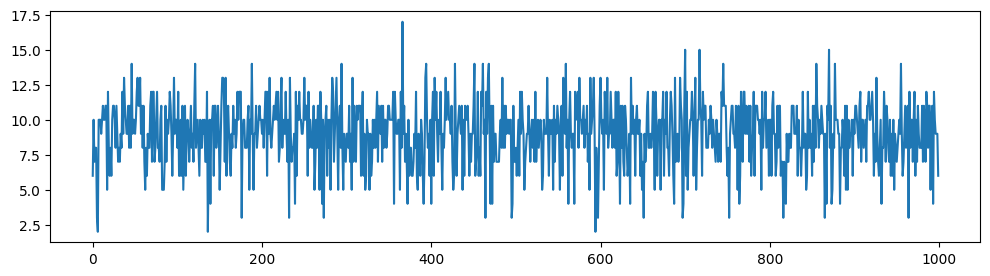

In [30]:
result = sim.sample(1000)

# for resulti in result:
#     plt.plot(result)
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(np.sum(result,axis=1))

plt.show()

In [12]:
m = rsc.matching()
m.num_nodes

# dont run this for too large a graph

from itertools import product

for z in list(product([True,False],repeat=m.num_nodes)):
    print(z, ': ', rsc.PredictedObservableOutcome(z,m))


(True, True, True, True, True, True, True, True, True, True, True, True, True, True) :  1
(True, True, True, True, True, True, True, True, True, True, True, True, True, False) :  0
(True, True, True, True, True, True, True, True, True, True, True, True, False, True) :  1
(True, True, True, True, True, True, True, True, True, True, True, True, False, False) :  0
(True, True, True, True, True, True, True, True, True, True, True, False, True, True) :  1
(True, True, True, True, True, True, True, True, True, True, True, False, True, False) :  0
(True, True, True, True, True, True, True, True, True, True, True, False, False, True) :  1
(True, True, True, True, True, True, True, True, True, True, True, False, False, False) :  0
(True, True, True, True, True, True, True, True, True, True, False, True, True, True) :  1
(True, True, True, True, True, True, True, True, True, True, False, True, True, False) :  0
(True, True, True, True, True, True, True, True, True, True, False, True, False, True

In [56]:

import sys
import plot_utils
import numpy as np
import json
import time
from multiprocessing import Pool

from RotatedSurfaceCode import RotatedSurfaceCode


# Nphi = 60

# pG = 0
# pTmax, pRmax = 0.06,0.17
# noisyLogRO = False
# Num_p,delpth = 5, 0.6

# Gbias, Tbias = 1, 20
# dmin,dmax = 11,17
# logical = 'X'
# # max_shots, shot_batch, max_num_fail, max_fail_rate = 30000, 300, 3000, 0.4
# max_shots, shot_batch, max_num_fail, max_fail_rate = 300, 3, 30, 0.4

def gen_surf_thresh_func_args(Nphi=60,pG=0,pTmax=0.06,pRmax=0.17,noisyLogRO=False,Num_p=5,delpth=0.6,Gbias=1,Tbias=20,dmin=11,dmax=17,logical='X',max_shots=30000):
    shot_batch = int(max_shots/10)
    max_num_fail = int(max_shots/10)
    max_fail_rate = 0.4
    slist = np.linspace(0,1,Nphi)
    pG_list,pT_list,pR_list = np.transpose([([pG,s*pTmax,(1-s)*pRmax]) for s in slist])
    phi_list = np.arctan2(pT_list,pG_list)
    theta_list = np.arctan2(pR_list,np.sqrt(pT_list**2 + pG_list**2))

    # results_threshold = []
    # results_full = []
    # outpath_threshold = './test_threshs.json'
    # outpath_full = './test.json'
    p_threshold_guess = np.sqrt(pG_list**2 + pT_list**2 + pR_list**2)

    def LogFail_of_d_p_arglist(arglist):
        return plot_utils.LogFail_of_d_p(RotatedSurfaceCode,
                                    theta = arglist[0], phi = arglist[1], Gbias = Gbias, Tbias = Tbias, logical = logical,
                                    dist_list = range(dmin,dmax+2,2), error_list = arglist[2]*np.linspace(1.-delpth,1.+delpth,Num_p), T_over_d = 1,
                                    max_shots = max_shots, shot_batch = shot_batch, max_num_fail = max_num_fail, max_fail_rate = max_fail_rate, noisyLogRO = noisyLogRO)
    args = [arglist for arglist in zip(theta_list,phi_list,p_threshold_guess)]
    return LogFail_of_d_p_arglist,args


In [ ]:
python3 generate_3d_plot.py code=RSC logical=X dmin=11 dmax=17 Tbias=20 Gbias=1 pGmax=0.007 pTmax=0.06 pRmax=0.07 Num_p=30 delpth=0.4 max_shots=300_000 shot_batch=3_000 max_num_fail=30_000 max_fail_rate=0.4 Nphi=$Nphi Nstart=$i;

In [142]:
import sys
import plot_utils
import numpy as np
import json
import time
from multiprocessing import Pool

from RotatedSurfaceCode import RotatedSurfaceCode

# Function moved to the global scope
def LogFail_of_d_p_arglist(arglist, Gbias, Tbias, logical, dmin, dmax, delpth, Num_p, max_shots, shot_batch, max_num_fail, max_fail_rate, noisyLogRO):
    return plot_utils.LogFail_of_d_p(
        RotatedSurfaceCode,
        theta=arglist[0], 
        phi=arglist[1], 
        Gbias=Gbias, 
        Tbias=Tbias, 
        logical=logical,
        dist_list=range(dmin, dmax + 2, 2), 
        error_list=arglist[2] * np.linspace(1. - delpth, 1. + delpth, Num_p), 
        T_over_d=1,
        max_shots=max_shots, 
        shot_batch=shot_batch, 
        max_num_fail=max_num_fail, 
        max_fail_rate=max_fail_rate, 
        noisyLogRO=noisyLogRO
    )

def gen_surf_thresh_func_args(
    Nphi=20, 
    pGmax=0.007,
    pTmax=0.06, 
    pRmax=0.07, 
    noisyLogRO=False, 
    Num_p=30, 
    delpth=0.4, 
    Gbias=1, 
    Tbias=20, 
    dmin=11, 
    dmax=17, 
    logical='X', 
    max_shots=30000
):
    shot_batch = int(max_shots / 10)
    max_num_fail = int(max_shots / 10)
    max_fail_rate = 0.4
    slist = np.linspace(0, 1, Nphi)
    tlist = np.linspace(0,1,Nphi)
    # pG_list, pT_list, pR_list = np.transpose(
    #     [([pG, s * pTmax, (1 - s) * pRmax]) for s in slist]
    # )
    pG_list,pT_list,pR_list = np.transpose([([(1-s-t)*pGmax,s*pTmax,t*pRmax]) for s in slist for t in tlist if s+t<=1])
    print(len(pG_list), len(pT_list), len(pR_list))
    phi_list = np.arctan2(pT_list, pG_list)
    theta_list = np.arctan2(pR_list, np.sqrt(pT_list**2 + pG_list**2))

    p_threshold_guess = np.sqrt(pG_list**2 + pT_list**2 + pR_list**2)
    args = [
        (arglist, Gbias, Tbias, logical, dmin, dmax, delpth, Num_p, max_shots, shot_batch, max_num_fail, max_fail_rate, noisyLogRO)
        for arglist in zip(theta_list, phi_list, p_threshold_guess)
    ]
    return LogFail_of_d_p_arglist, args


In [156]:
from itertools import islice, zip_longest

def batched(iterable, n):
    "Batch data into lists of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            return
        yield batch

In [144]:
p = Pool(16)

func,args = gen_surf_thresh_func_args(max_shots=300,logical='X')
result_X = p.starmap(func,args)

func,args = gen_surf_thresh_func_args(max_shots=300,logical='Z')
result_Z = p.starmap(func,args)

210 210 210
210 210 210


In [145]:
def result2sthreshs(result):
    LogZ_fail_3d_d_p = []
    for row in range(len(result)):        
        LogZ_fail_3d_d_p_col = []
        for col in range(len(result[row])):
            theta1, phi1, Log_fail_d_p = result[row][col]
            p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
            LogZ_fail_3d_d_p_col.append([theta1, phi1, p_threshold, p_threshold_error])
        LogZ_fail_3d_d_p.append(LogZ_fail_3d_d_p_col)
    return LogZ_fail_3d_d_p

LogX_fail_3d_d_p = result2sthreshs(list(batched(result_X,20)))
LogZ_fail_3d_d_p = result2sthreshs(list(batched(result_Z,20)))


In [154]:
import pickle
# with open('./RSC_3d_LogX_fail3d_d_p.pkl','wb') as f:    
#     pickle.dump(LogX_fail_3d_d_p,f)
# with open('./RSC_3d_LogZ_fail3d_d_p.pkl','wb') as f:    
#     pickle.dump(LogZ_fail_3d_d_p,f)
with open('./RSC_3d_LogX_fail3d_d_p.pkl','rb') as f:    
    LogX_fail_3d_d_p = pickle.load(f)
with open('./RSC_3d_LogZ_fail3d_d_p.pkl','rb') as f:    
    LogZ_fail_3d_d_p = pickle.load(f)

In [131]:
code, dmax, logicals = ['RSC', '17', ['X','Z']]


findfont: Font family 'times' not found.
findfont: Font family 'times' not found.


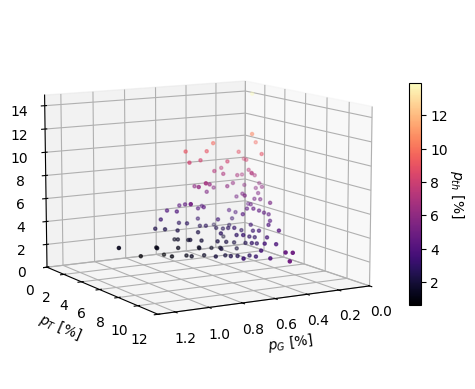

In [155]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# pG = 0
# pT = 
# p_physRR = np.sqrt(pG**2 + pT**2 + pRR**2)
# thetaRR = np.arctan2(pRR,np.sqrt(pT**2 + pG**2))

poptlist,pfiterr,std,maxdev = plot_utils.fit_plane(LogX_fail_3d_d_p,LogZ_fail_3d_d_p)
plot_utils.plot_3d_threshold(LogX_fail_3d_d_p,LogZ_fail_3d_d_p,ax=ax,cmap='magma',truncate=False, alpha=0.)
ax.set_xticks(np.arange(0,1.8,0.2))
ax.set_xlim(0,1.3)
ax.set_ylim(0,12)
ax.set_zlim(0,)
# fig.tight_layout()
ax.view_init(elev=10., azim=60)
plt.show()